In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
import numpy as np
import utils
import matplotlib.pyplot as plt
from datasets import GenderRGB

In [124]:
args = {}
args["data_dir"] = "data/Gender01"
args["data"] = "gender"
args["lr"] = 0.001
args["lr"] = 0.0003
utils.split_train_to_val(args["data"], args["data_dir"], val_ratio=0.1)

In [125]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["train", "val"]
        )

In [126]:
import timm
import torch.nn.functional as F

class WarmUpResNet(nn.Module):
    def __init__(
        self, backbone="resnet18"
    ):
        super(WarmUpResNet, self).__init__()
        self.backbone = timm.create_model('resnet18', pretrained=True, num_classes=256)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x


In [127]:
device = utils.get_device("mps")
model = WarmUpResNet()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
model = model.to(device)

In [128]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [90]:
images, masks = next(iter(dataloaders["train"]))
print(images.shape, masks.shape)

torch.Size([4, 1, 256, 256]) torch.Size([4, 1])


In [129]:
def map_logit_class(logits):
    female=(logits>0.5).int()
    female = [GenderRGB.inverse_label_mapping[value.item()] for value in female]
    return female[0]

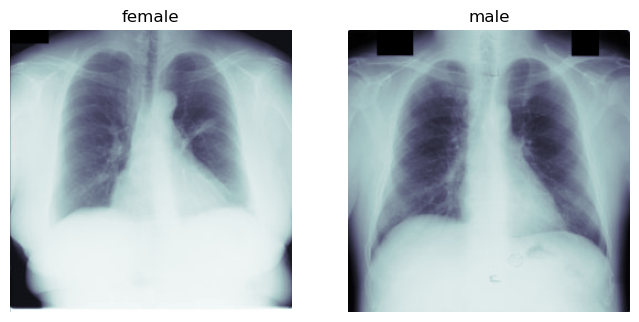

In [92]:
fig = plt.figure(figsize=(8,4))
fig.add_subplot(121)
plt.imshow(image_to_arrag(images[0]), cmap=plt.cm.bone)
plt.title(map_logit_class(masks[0]))
plt.axis("off")
fig.add_subplot(122)
plt.imshow(image_to_arrag(images[2]), cmap=plt.cm.bone)
plt.title(map_logit_class(masks[2]))
plt.axis("off")
plt.show()

In [130]:
from tqdm import tqdm
def train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, num_epochs):
    model.train()
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
            else:
                model.eval()
            running_loss=0.0
            with tqdm(total=len(dataloaders[phase]), desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase=="train"):
                        outputs = model(inputs.repeat(1,3,1,1))
                        loss = loss_fn(outputs, labels)
                        if phase=="train":
                            loss.backward()
                            optimizer.step()
                        running_loss += loss.item()
                    pbar.update(1)
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, 20)

Val Epoch 1/20: 100%|██████████| 4/4 [00:22<00:00,  5.53s/batch]


Epoch 1/20 -> Train Loss: 0.1710, Val Loss: 0.1759


Val Epoch 2/20: 100%|██████████| 4/4 [00:22<00:00,  5.59s/batch]


Epoch 2/20 -> Train Loss: 0.1426, Val Loss: 0.1497


Val Epoch 3/20: 100%|██████████| 4/4 [00:22<00:00,  5.65s/batch]


Epoch 3/20 -> Train Loss: 0.1101, Val Loss: 0.0945


Val Epoch 4/20: 100%|██████████| 4/4 [00:22<00:00,  5.51s/batch]


Epoch 4/20 -> Train Loss: 0.0707, Val Loss: 0.0884


Val Epoch 5/20: 100%|██████████| 4/4 [00:22<00:00,  5.55s/batch]


Epoch 5/20 -> Train Loss: 0.0641, Val Loss: 0.0730


Val Epoch 6/20: 100%|██████████| 4/4 [00:22<00:00,  5.57s/batch]


Epoch 6/20 -> Train Loss: 0.0290, Val Loss: 0.0828


Val Epoch 7/20: 100%|██████████| 4/4 [00:22<00:00,  5.60s/batch]


Epoch 7/20 -> Train Loss: 0.0232, Val Loss: 0.0399


Val Epoch 8/20: 100%|██████████| 4/4 [00:22<00:00,  5.52s/batch]


Epoch 8/20 -> Train Loss: 0.0232, Val Loss: 0.0675


Val Epoch 9/20: 100%|██████████| 4/4 [00:22<00:00,  5.58s/batch]


Epoch 9/20 -> Train Loss: 0.0408, Val Loss: 0.0715


Val Epoch 10/20: 100%|██████████| 4/4 [00:22<00:00,  5.57s/batch]


Epoch 10/20 -> Train Loss: 0.0394, Val Loss: 0.0679


Val Epoch 11/20: 100%|██████████| 4/4 [00:22<00:00,  5.61s/batch]


Epoch 11/20 -> Train Loss: 0.0169, Val Loss: 0.0092


Val Epoch 12/20: 100%|██████████| 4/4 [00:22<00:00,  5.54s/batch]


Epoch 12/20 -> Train Loss: 0.0036, Val Loss: 0.0106


Val Epoch 13/20: 100%|██████████| 4/4 [00:22<00:00,  5.59s/batch]


Epoch 13/20 -> Train Loss: 0.0061, Val Loss: 0.0108


Val Epoch 14/20: 100%|██████████| 4/4 [00:22<00:00,  5.60s/batch]


Epoch 14/20 -> Train Loss: 0.0020, Val Loss: 0.1127


Val Epoch 15/20: 100%|██████████| 4/4 [00:22<00:00,  5.53s/batch]


Epoch 15/20 -> Train Loss: 0.0013, Val Loss: 0.0144


Val Epoch 16/20: 100%|██████████| 4/4 [00:22<00:00,  5.55s/batch]


Epoch 16/20 -> Train Loss: 0.0034, Val Loss: 0.0180


Val Epoch 17/20: 100%|██████████| 4/4 [00:22<00:00,  5.53s/batch]


Epoch 17/20 -> Train Loss: 0.0025, Val Loss: 0.0464


Val Epoch 18/20: 100%|██████████| 4/4 [00:22<00:00,  5.51s/batch]


Epoch 18/20 -> Train Loss: 0.0010, Val Loss: 0.0078


Val Epoch 19/20: 100%|██████████| 4/4 [00:22<00:00,  5.54s/batch]


Epoch 19/20 -> Train Loss: 0.0016, Val Loss: 0.0050


Val Epoch 20/20: 100%|██████████| 4/4 [00:22<00:00,  5.55s/batch]

Epoch 20/20 -> Train Loss: 0.0005, Val Loss: 0.0047


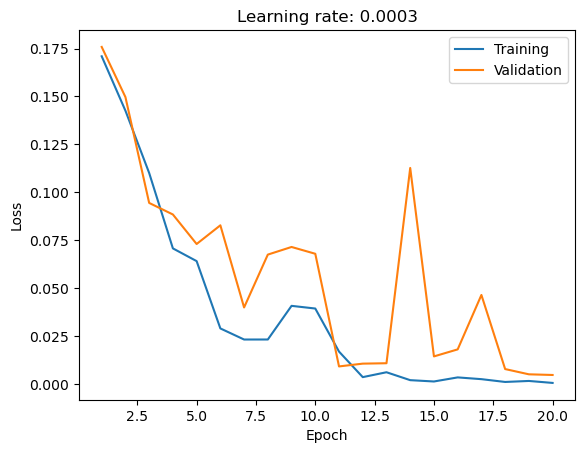

In [131]:
def plot_loss(train_losses, val_losses, learning_rate):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning rate: {learning_rate}")
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses, args["lr"])

In [132]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["test"]
        )

In [133]:
def test_model(model, loss_fn, dataloader, dataset_size):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_targets = []
    all_inputs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.repeat(1,3,1,1))
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_targets.append(labels.cpu())
            all_inputs.append(inputs.cpu())
    test_loss = test_loss / dataset_size
    all_inputs, all_outputs, all_targets = torch.cat(all_inputs), torch.cat(all_outputs), torch.cat(all_targets)
    print(f"Test Loss: {test_loss:.4f}")
    return all_inputs, all_outputs, all_targets
inputs, outputs, targets = test_model(model, loss_fn, dataloaders["test"], dataset_sizes["test"])

Test Loss: 0.1570


In [36]:
from sklearn.metrics import roc_auc_score, accuracy_score
print(f"AUC: {roc_auc_score(targets, outputs)}")
print(f"ACC: {accuracy_score(targets, (outputs>0.5).float().numpy())}")

AUC: 0.9470121381886087
ACC: 0.9032258064516129


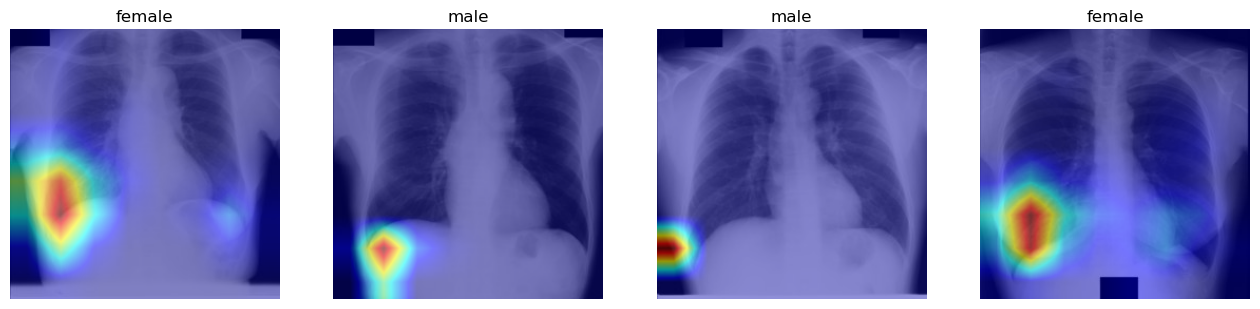

In [137]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


def get_grad_cam(input_tensor):
    input_tensor = input_tensor.unsqueeze(dim=0).repeat(1,3,1,1)
    target_layers = [model.backbone.layer4[-1]]
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(image_to_arrag(input_tensor.squeeze()), grayscale_cam, use_rgb=True)
        return visualization

fig = plt.figure(figsize=(16,4))
fig.add_subplot(141)
plt.imshow(get_grad_cam(inputs[0]))
plt.title(map_logit_class(outputs[0]))
plt.axis("off")
fig.add_subplot(142)
plt.imshow(get_grad_cam(inputs[3]))
plt.title(map_logit_class(outputs[3]))
plt.axis("off")
fig.add_subplot(143)
plt.imshow(get_grad_cam(inputs[2]))
plt.title(map_logit_class(outputs[2]))
plt.axis("off")
fig.add_subplot(144)
plt.imshow(get_grad_cam(inputs[12]))
plt.title(map_logit_class(outputs[12]))
plt.axis("off")
plt.show()

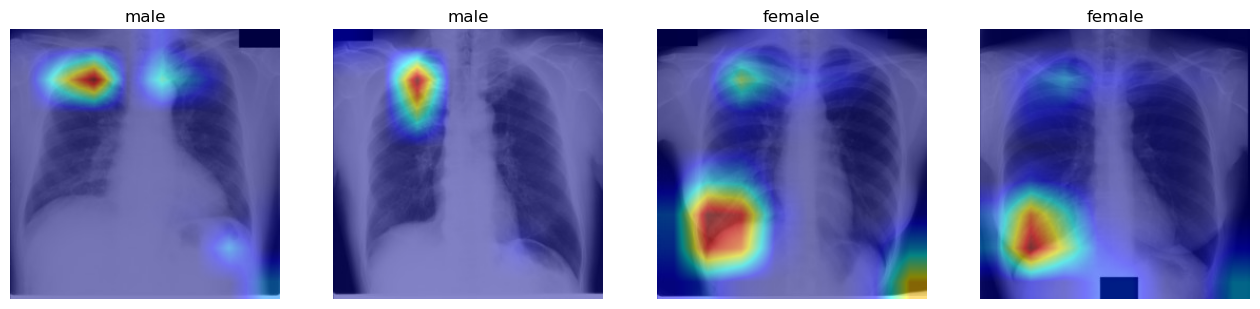

In [79]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


def get_grad_cam(input_tensor):
    input_tensor = input_tensor.unsqueeze(dim=0).repeat(1,3,1,1)
    target_layers = [model.backbone.layer4[-1]]
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(image_to_arrag(input_tensor.squeeze()), grayscale_cam, use_rgb=True)
        return visualization

fig = plt.figure(figsize=(16,4))
fig.add_subplot(141)
plt.imshow(get_grad_cam(inputs[0]))
plt.title(map_logit_class(outputs[0]))
plt.axis("off")
fig.add_subplot(142)
plt.imshow(get_grad_cam(inputs[1]))
plt.title(map_logit_class(outputs[1]))
plt.axis("off")
fig.add_subplot(143)
plt.imshow(get_grad_cam(inputs[2]))
plt.title(map_logit_class(outputs[2]))
plt.axis("off")
fig.add_subplot(144)
plt.imshow(get_grad_cam(inputs[12]))
plt.title(map_logit_class(outputs[12]))
plt.axis("off")
plt.show()